In [2]:
# === Bibliotecas ===
import pandas as pd

# === Caminhos dos arquivos ===
paths = {
    "jitter": "df_mort_deng_jitter_sigma_0.1.csv",
    "spline": "cubic_spline.csv",
    "pib": "PIB_per_Capita_CA.xlsx",
    "dens": "Densidade_Demog_CA.xlsx",
    "urb": "indice_urbanização_CA.xlsx",
    "co2": "GEE_CO2_CA.xlsx",
    "ch4": "GEE_CH4_CA.xlsx",
    "n2o": "GEE_N2O_CA.xlsx",
    "coords": "Lat_Long_Mun_CA.xlsx",
}

# === Séries temporais interpoladas (semanal) ===
df_jitter = pd.read_csv(paths["jitter"], index_col=0)
df_spline = pd.read_csv(paths["spline"], index_col=0)

# Visualização opcional
print("Jitter shape:", df_jitter.shape)
print("Spline shape:", df_spline.shape)

Jitter shape: (5570, 624)
Spline shape: (5570, 1200)


In [4]:
# Ler os dados exógenos
df_pib = pd.read_excel(paths["pib"])
df_dens = pd.read_excel(paths["dens"])
df_urb = pd.read_excel(paths["urb"])
df_co2 = pd.read_excel(paths["co2"])
df_ch4 = pd.read_excel(paths["ch4"])
df_n2o = pd.read_excel(paths["n2o"])
df_coords = pd.read_excel(paths["coords"])

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [5]:
# Para PIB, Densidade e Urbanização, defina "CD_MUN" como índice
df_pib.set_index("CD_MUN", inplace=True)
df_dens.set_index("CD_MUN", inplace=True)
df_urb.set_index("CD_MUN", inplace=True)

# Para CO2, CH4, e N2O, use "COD_MUN" como índice
df_co2.set_index("COD_MUN", inplace=True)
df_ch4.set_index("COD_MUN", inplace=True)
df_n2o.set_index("COD_MUN", inplace=True)

# Ajuste das Coordenadas: usar a coluna "Codigo"
df_coords_clean = df_coords[["Codigo", "lat", "long"]].copy()
df_coords_clean.columns = ["CD_MUN", "LAT", "LON"]
df_coords_clean["CD_MUN"] = df_coords_clean["CD_MUN"].astype(int)
df_coords_clean.set_index("CD_MUN", inplace=True)


In [6]:
# Esta função mapeia cada semana para um ano (assumindo 52 semanas/ano)
def map_weeks_to_years(start_year=1999, weeks=1200):
    return pd.Series([start_year + i // 52 for i in range(weeks)], index=range(weeks))

week_to_year = map_weeks_to_years()


In [7]:
# Função para extrair apenas as colunas que contenham o prefixo e converter os nomes em inteiros
def clean_year_columns(df, prefix):
    df = df.filter(like=prefix, axis=1)
    df.columns = df.columns.str.extract(r"(\d+)")[0].astype(int)
    return df

# Função otimizada para expandir dados anuais para granularidade semanal
def optimized_expand(df_annual, week_to_year_map):
    common_years = [year for year in week_to_year_map.unique() if year in df_annual.columns]
    df_annual = df_annual[common_years]
    week_year_array = week_to_year_map.map(lambda y: y if y in common_years else np.nan).to_numpy()
    data = np.full((df_annual.shape[0], len(week_to_year_map)), np.nan)
    year_to_col = {year: idx for idx, year in enumerate(df_annual.columns)}
    for col_idx, year in enumerate(week_year_array):
        if not np.isnan(year):
            data[:, col_idx] = df_annual.iloc[:, year_to_col[year]].to_numpy()
    return pd.DataFrame(data, index=df_annual.index, columns=range(len(week_to_year_map)))


In [8]:
import numpy as np
# Para PIB, Densidade e Urbanização (utilizam prefixos "PIB_", "DM_" e "A")
df_pib_years = clean_year_columns(df_pib, "PIB_")
weekly_pib = optimized_expand(df_pib_years, week_to_year)

# Limpar e selecionar apenas colunas DM_*
# Corrigir o nome das colunas DM_99 → 1999, DM_00 → 2000, etc.
df_dens_years = clean_year_columns(df_dens, "DM_")

# Ajustar os anos: valores < 100 assumimos que são 2000+, exceto 99 = 1999
df_dens_years.columns = df_dens_years.columns.map(lambda y: 1999 if y == 99 else 2000 + y if y < 100 else y)

# Reaplicar interpolação por linha
df_dens_years = df_dens_years.T.fillna(df_dens_years.T.mean()).T

# Garantir que colunas e índices estão no tipo certo
df_dens_years.columns = df_dens_years.columns.astype(int)
df_dens_years.index = df_dens_years.index.astype(int)

# Reexpandir para granularidade semanal
weekly_dens = optimized_expand(df_dens_years, week_to_year)

df_urb_years = clean_year_columns(df_urb, "A")
weekly_urb = optimized_expand(df_urb_years, week_to_year)

# Para CO2, CH4 e N2O (as colunas já são numéricas)
df_co2_years = df_co2.loc[:, df_co2.columns.map(lambda x: isinstance(x, int))]
weekly_co2 = optimized_expand(df_co2_years, week_to_year)

df_ch4_years = df_ch4.loc[:, df_ch4.columns.map(lambda x: isinstance(x, int))]
weekly_ch4 = optimized_expand(df_ch4_years, week_to_year)

df_n2o_years = df_n2o.loc[:, df_n2o.columns.map(lambda x: isinstance(x, int))]
weekly_n2o = optimized_expand(df_n2o_years, week_to_year)


In [9]:
# Função para padronizar os índices, preenchendo com zeros à esquerda
def padronizar_index(df):
    df.index = df.index.astype(str).str.zfill(7).astype(int)
    return df

weekly_pib = padronizar_index(weekly_pib)
weekly_dens = padronizar_index(weekly_dens)
weekly_urb = padronizar_index(weekly_urb)
weekly_co2 = padronizar_index(weekly_co2)
weekly_ch4 = padronizar_index(weekly_ch4)
weekly_n2o = padronizar_index(weekly_n2o)
df_jitter = padronizar_index(df_jitter)
df_coords_clean = padronizar_index(df_coords_clean)


In [10]:
# Função para empilhar um DataFrame de wide para long
def stack_series(df, name):
    df_stacked = df.stack().reset_index()
    df_stacked.columns = ["CD_MUN", "week", name]
    return df_stacked

# Empilhando a série alvo (df_jitter)
df_base = stack_series(df_jitter, "target")
df_base["week"] = df_base["week"].astype(int)

# Merge dos exógenos
df_base = df_base.merge(stack_series(weekly_pib, "PIB"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(stack_series(weekly_dens, "DENS"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(stack_series(weekly_urb, "URB"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(stack_series(weekly_co2, "CO2"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(stack_series(weekly_ch4, "CH4"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(stack_series(weekly_n2o, "N2O"), on=["CD_MUN", "week"], how="left")
df_base = df_base.merge(df_coords_clean, on="CD_MUN", how="left")

# Visualizar resultado
df_base.head()


,CD_MUN,week,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
0,1100015,0,0.000000,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
1,1100015,1,0.000000,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
2,1100015,2,0.000000,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
3,1100015,3,0.000000,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
4,1100015,4,1.071507,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39


In [11]:
def create_supervised_dataset(df, lookback=4, target_col='target', features=None):
    """
    Cria dataset supervisionado multivariado para previsão t+1.
    
    Args:
        df (DataFrame): base contendo CD_MUN, week, target, features...
        lookback (int): número de semanas anteriores a usar como input
        target_col (str): nome da coluna a prever
        features (list): lista de features a usar como input (None = usar todas exceto CD_MUN, week, target)
    
    Returns:
        X: array [amostras, lookback, features]
        y: array [amostras]
        municipios: lista com o código do município de cada amostra
    """
    from numpy.lib.stride_tricks import sliding_window_view
    
    if features is None:
        features = [col for col in df.columns if col not in ['CD_MUN', 'week', target_col]]
    
    X_all, y_all, municipios = [], [], []
    
    for mun, df_mun in df.groupby("CD_MUN"):
        df_mun = df_mun.sort_values("week")
        if df_mun.shape[0] <= lookback:
            continue
        data = df_mun[features + [target_col]].to_numpy()
        
        X_mun = sliding_window_view(data, window_shape=(lookback + 1), axis=0)
        for x in X_mun:
            X_all.append(x[:-1, :-1])  # features (t-lookback a t-1)
            y_all.append(x[-1, -1])    # target (t)
            municipios.append(mun)
    
    return np.array(X_all), np.array(y_all), np.array(municipios)


In [15]:
# Save df_base to CSV file
df_base.to_csv("df_base_mort_dengue.csv", index=False)
print(f"DataFrame saved to df_base.csv with {df_base.shape[0]} rows and {df_base.shape[1]} columns")

DataFrame saved to df_base.csv with 3475680 rows and 11 columns


In [12]:
X, y, mun_ids = create_supervised_dataset(df_base, lookback=8)
print(X.shape, y.shape)


(3431120, 8, 8) (3431120,)


In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def normalize_and_split(X, y, municipios, train_ratio=0.6, val_ratio=0.2):
    """
    Normaliza os dados por município e separa em treino/validação/teste temporal.
    NaNs são preenchidos com a média por linha (município).
    
    Args:
        X: array [n_amostras, janela, n_features]
        y: array [n_amostras]
        municipios: array [n_amostras]
        train_ratio (float)
        val_ratio (float)
        
    Returns:
        Dicionário com X_train, X_val, X_test, y_train, y_val, y_test
    """
    X_norm = np.empty_like(X)
    splits = {"train": [], "val": [], "test": []}
    
    unique_muns = np.unique(municipios)
    
    for mun in unique_muns:
        idx = np.where(municipios == mun)[0]
        X_mun, y_mun = X[idx], y[idx]
        n = len(idx)
        
        # Split temporal
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val
        
        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]

        X_train_flat = X[train_idx].reshape(-1, X.shape[-1])

        # Imputar NaNs com a média por linha (sem warnings!)
        X_train_flat = pd.DataFrame(X_train_flat).T.ffill().bfill().fillna(0).T.to_numpy()

        if X_train_flat.shape[0] < 2:
            print(f"[!] Município {mun} ignorado: dados insuficientes mesmo após imputação.")
            continue

        scaler = StandardScaler()
        scaler.fit(X_train_flat)

        for i in idx:
            X_muni = pd.DataFrame(X[i]).T.ffill().bfill().fillna(0).T.to_numpy()
            X_norm[i] = scaler.transform(X_muni)

        splits["train"].extend(train_idx)
        splits["val"].extend(val_idx)
        splits["test"].extend(test_idx)
    
    # Separar os conjuntos
    X_train = X_norm[splits["train"]]
    y_train = y[splits["train"]]

    X_val = X_norm[splits["val"]]
    y_val = y[splits["val"]]

    X_test = X_norm[splits["test"]]
    y_test = y[splits["test"]]

    return {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val, "y_val": y_val,
        "X_test": X_test, "y_test": y_test
    }


In [14]:
dataset = normalize_and_split(X, y, mun_ids)

print("Train shape:", dataset["X_train"].shape)
print("Val shape:", dataset["X_val"].shape)
print("Test shape:", dataset["X_test"].shape)


KeyboardInterrupt: 

In [12]:
import numpy as np

def sample_subset(X, y, municipios, n_municipios=300, random_state=42):
    np.random.seed(random_state)
    mun_unique = np.unique(municipios)
    mun_sample = np.random.choice(mun_unique, size=n_municipios, replace=False)
    mask = np.isin(municipios, mun_sample)
    return X[mask], y[mask], municipios[mask]

# Subconjunto para testes locais
X_sub, y_sub, mun_ids_sub = sample_subset(X, y, mun_ids, n_municipios=300)


In [13]:
dataset = normalize_and_split(X_sub, y_sub, mun_ids_sub)


In [14]:
print("Train shape:", dataset["X_train"].shape)
print("Val shape:", dataset["X_val"].shape)
print("Test shape:", dataset["X_test"].shape)

Train shape: (214500, 8, 8)
Val shape: (71400, 8, 8)
Test shape: (71700, 8, 8)


In [ ]:
pip install --upgrade scikit-learn

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Função de avaliação por faixa de valor real (t+1)
def evaluate_by_range(y_true, y_pred, bins=None):
    if bins is None:
        bins = [0, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, np.inf]

    labels = [f"[{bins[i]}, {bins[i+1]})" for i in range(len(bins)-1)]

    df = pd.DataFrame({
        "real": y_true,
        "pred": y_pred,
        "faixa": pd.cut(y_true, bins=bins, labels=labels, include_lowest=True)
    })

    grouped = df.groupby("faixa", observed=True).apply(
        lambda g: pd.Series({
            "Qtd. Amostras": len(g),
            "RMSE": np.sqrt(mean_squared_error(g["real"], g["pred"])),
            "MAE": mean_absolute_error(g["real"], g["pred"]),
            "R2": r2_score(g["real"], g["pred"]) if len(g) > 1 else np.nan
        })
    ).reset_index()

    return grouped


# === Função para visualização
def plot_range_metrics(df, metric="MAE"):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="faixa", y=metric, data=df, palette="viridis")
    plt.title(f"{metric} por Faixa de Valor Real (t+1)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



,RMSE,MAE,R2
train,1.4547,0.4116,0.0349
val,1.9169,0.5077,0.0346
test,1.7227,0.5005,0.0353


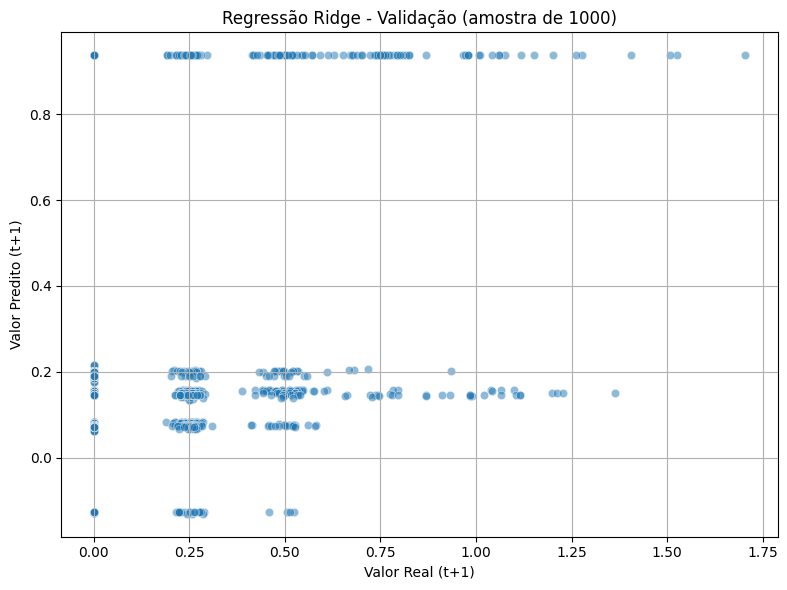

In [16]:
# RIDGE
# === IMPORTS ===
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === FORMATAÇÃO DOS DADOS ===
# (Ajuste caso ainda não tenha feito)
X_train = dataset["X_train"].reshape(dataset["X_train"].shape[0], -1)
X_val = dataset["X_val"].reshape(dataset["X_val"].shape[0], -1)
X_test = dataset["X_test"].reshape(dataset["X_test"].shape[0], -1)

y_train = dataset["y_train"]
y_val = dataset["y_val"]
y_test = dataset["y_test"]

# === MODELO RIDGE ===
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# === PREDIÇÕES ===
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# === MÉTRICAS ===
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


metrics = {
    "train": compute_metrics(y_train, y_pred_train),
    "val": compute_metrics(y_val, y_pred_val),
    "test": compute_metrics(y_test, y_pred_test),
}

# === MOSTRAR MÉTRICAS ===
metrics_df = pd.DataFrame(metrics).T.round(4)
display(metrics_df)  # Use print(metrics_df) se estiver fora do Jupyter

# === GRÁFICO REAL vs PREDITO (validação) ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val[:1000], y=y_pred_val[:1000], alpha=0.5)
plt.xlabel("Valor Real (t+1)")
plt.ylabel("Valor Predito (t+1)")
plt.title("Regressão Ridge - Validação (amostra de 1000)")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Percentual de zeros:
Treino:     63.37%
Validação:  51.99%
Teste:      47.84%


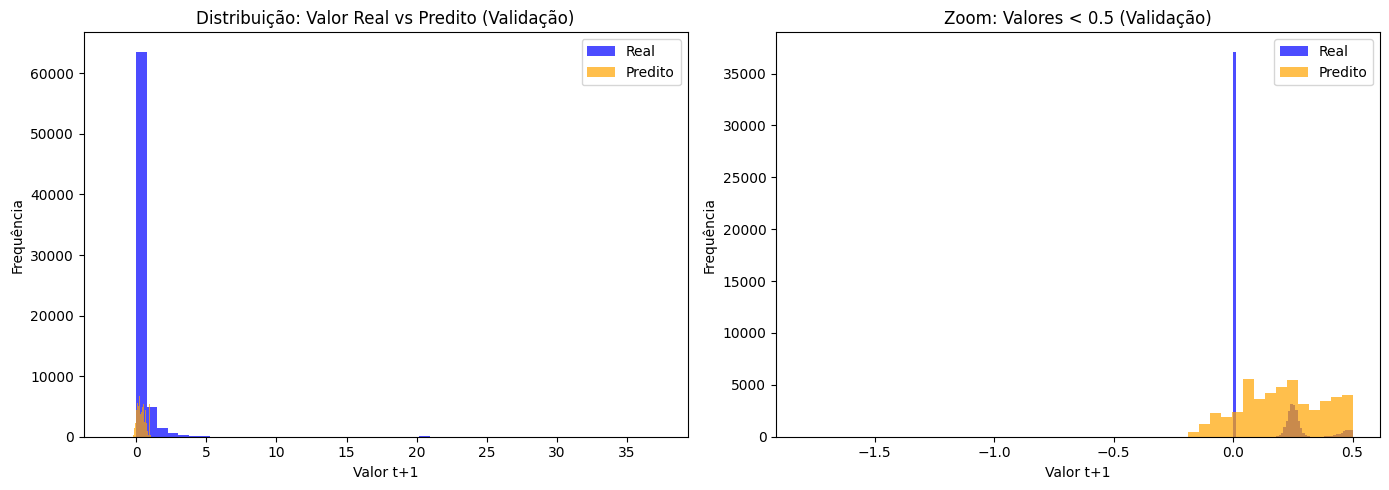

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def avaliar_esparsidade(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test):
    def percent_zeros(y):
        return 100 * np.sum(y == 0) / len(y)

    print("🔍 Percentual de zeros:")
    print(f"Treino:     {percent_zeros(y_train):.2f}%")
    print(f"Validação:  {percent_zeros(y_val):.2f}%")
    print(f"Teste:      {percent_zeros(y_test):.2f}%")

    # Histograma dos valores reais
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.hist(y_val, bins=50, alpha=0.7, label="Real", color="blue")
    plt.hist(y_pred_val, bins=50, alpha=0.7, label="Predito", color="orange")
    plt.title("Distribuição: Valor Real vs Predito (Validação)")
    plt.xlabel("Valor t+1")
    plt.ylabel("Frequência")
    plt.legend()

    # Zoom para valores baixos (efeito da esparsidade)
    plt.subplot(1, 2, 2)
    plt.hist(y_val[y_val < 0.5], bins=50, alpha=0.7, label="Real", color="blue")
    plt.hist(y_pred_val[y_pred_val < 0.5], bins=50, alpha=0.7, label="Predito", color="orange")
    plt.title("Zoom: Valores < 0.5 (Validação)")
    plt.xlabel("Valor t+1")
    plt.ylabel("Frequência")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Uso:
avaliar_esparsidade(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test)


In [ ]:
pip install -U xgboost

[0]	validation_0-rmse:1.87357
[1]	validation_0-rmse:1.80410
[2]	validation_0-rmse:1.74515
[3]	validation_0-rmse:1.69604
[4]	validation_0-rmse:1.65266
[5]	validation_0-rmse:1.61528
[6]	validation_0-rmse:1.58594
[7]	validation_0-rmse:1.56000
[8]	validation_0-rmse:1.54050
[9]	validation_0-rmse:1.52384
[10]	validation_0-rmse:1.50938
[11]	validation_0-rmse:1.49622
[12]	validation_0-rmse:1.48532
[13]	validation_0-rmse:1.47880
[14]	validation_0-rmse:1.47140
[15]	validation_0-rmse:1.46528
[16]	validation_0-rmse:1.45999
[17]	validation_0-rmse:1.45659
[18]	validation_0-rmse:1.45339
[19]	validation_0-rmse:1.45053
[20]	validation_0-rmse:1.44686
[21]	validation_0-rmse:1.44481
[22]	validation_0-rmse:1.44335
[23]	validation_0-rmse:1.44173
[24]	validation_0-rmse:1.43930
[25]	validation_0-rmse:1.43848
[26]	validation_0-rmse:1.43759
[27]	validation_0-rmse:1.43742
[28]	validation_0-rmse:1.43698
[29]	validation_0-rmse:1.43547
[30]	validation_0-rmse:1.43499
[31]	validation_0-rmse:1.43464
[32]	validation_0-

,RMSE,MAE,R2
train,0.9975,0.2543,0.5462
val,1.4212,0.3706,0.4694
test,1.3675,0.4164,0.3921


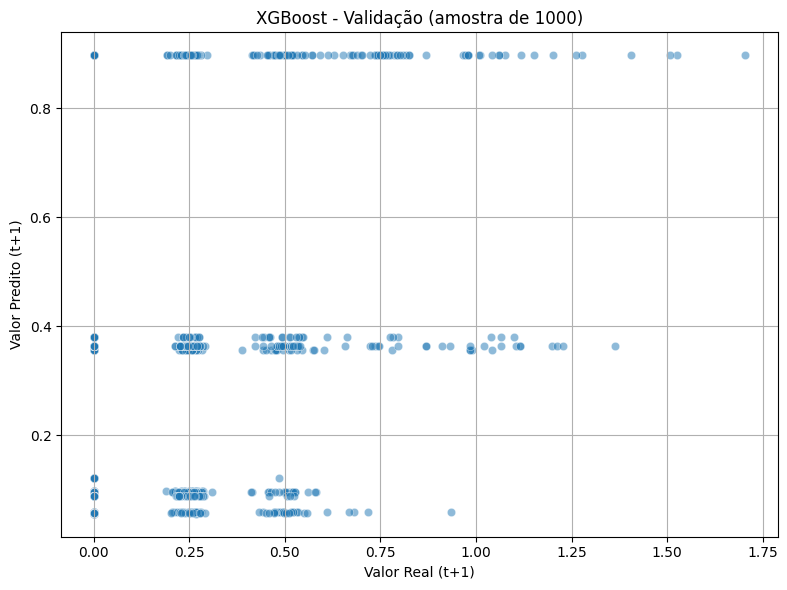

In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === FORMATANDO OS DADOS ===
X_train_flat = dataset["X_train"].reshape(dataset["X_train"].shape[0], -1)
X_val_flat = dataset["X_val"].reshape(dataset["X_val"].shape[0], -1)
X_test_flat = dataset["X_test"].reshape(dataset["X_test"].shape[0], -1)

y_train = dataset["y_train"]
y_val = dataset["y_val"]
y_test = dataset["y_test"]

# === MODELO XGBOOST ===
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',  # mais rápido se estiver disponível
    early_stopping_rounds=10,  # Definido na inicialização
    eval_metric="rmse"  # Definido na inicialização
)

# === TREINAMENTO ===
model_xgb.fit(
    X_train_flat, y_train,
    eval_set=[(X_val_flat, y_val)],
    verbose=True
)

# === PREDIÇÕES ===
y_pred_train = model_xgb.predict(X_train_flat)
y_pred_val = model_xgb.predict(X_val_flat)
y_pred_test = model_xgb.predict(X_test_flat)

# === MÉTRICAS ===
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

metrics = {
    "train": compute_metrics(y_train, y_pred_train),
    "val": compute_metrics(y_val, y_pred_val),
    "test": compute_metrics(y_test, y_pred_test),
}

# === MOSTRAR MÉTRICAS ===
metrics_df = pd.DataFrame(metrics).T.round(4)
display(metrics_df)

# === GRÁFICO REAL vs PREDITO (Validação) ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val[:1000], y=y_pred_val[:1000], alpha=0.5)
plt.xlabel("Valor Real (t+1)")
plt.ylabel("Valor Predito (t+1)")
plt.title("XGBoost - Validação (amostra de 1000)")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Percentual de zeros:
Treino:     63.37%
Validação:  51.99%
Teste:      47.84%


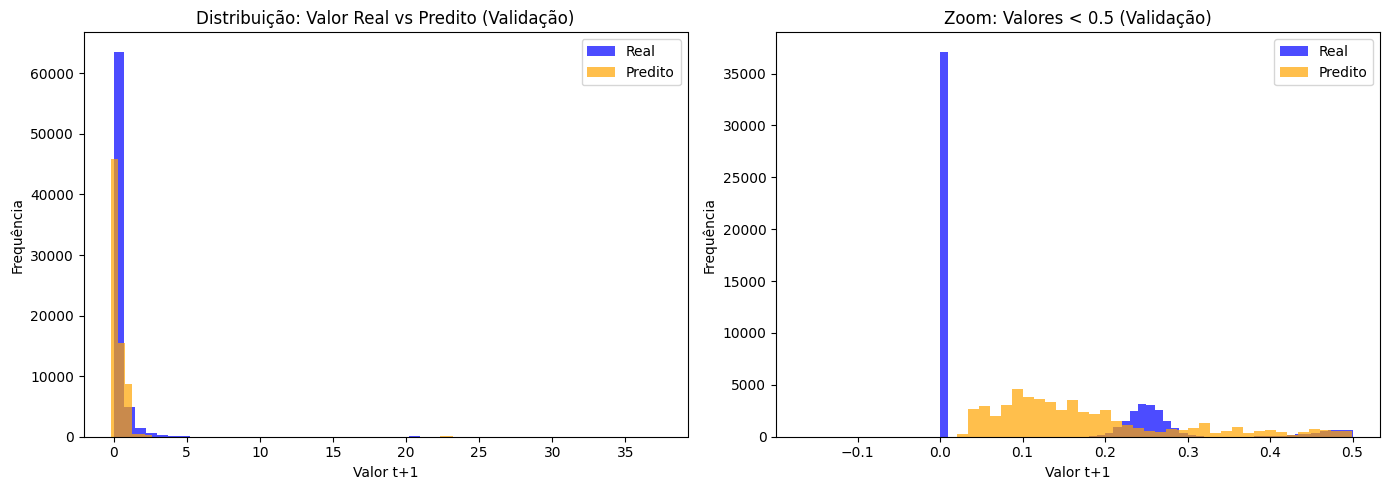

In [19]:
avaliar_esparsidade(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test)

C:\Users\pedro\AppData\Local\Temp\ipykernel_10008\385005573.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("faixa", observed=True).apply(


,faixa,Qtd. Amostras,RMSE,MAE,R2
0,"[0, 0.01)",37119.0,0.334787,0.233559,0.000000
1,"[0.1, 0.5)",21070.0,0.270095,0.201020,-8.885079
2,"[0.5, 1.0)",8005.0,0.378578,0.326373,-5.493543
3,"[1.0, 2.0)",3356.0,0.758292,0.678795,-6.123673
4,"[2.0, 5.0)",1290.0,1.709202,1.525711,-4.820355
5,"[5.0, 10.0)",84.0,5.079142,4.888016,-20.094888
6,"[10.0, inf)",476.0,16.493864,13.211171,-11.891570


C:\Users\pedro\AppData\Local\Temp\ipykernel_10008\385005573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="faixa", y=metric, data=df, palette="viridis")


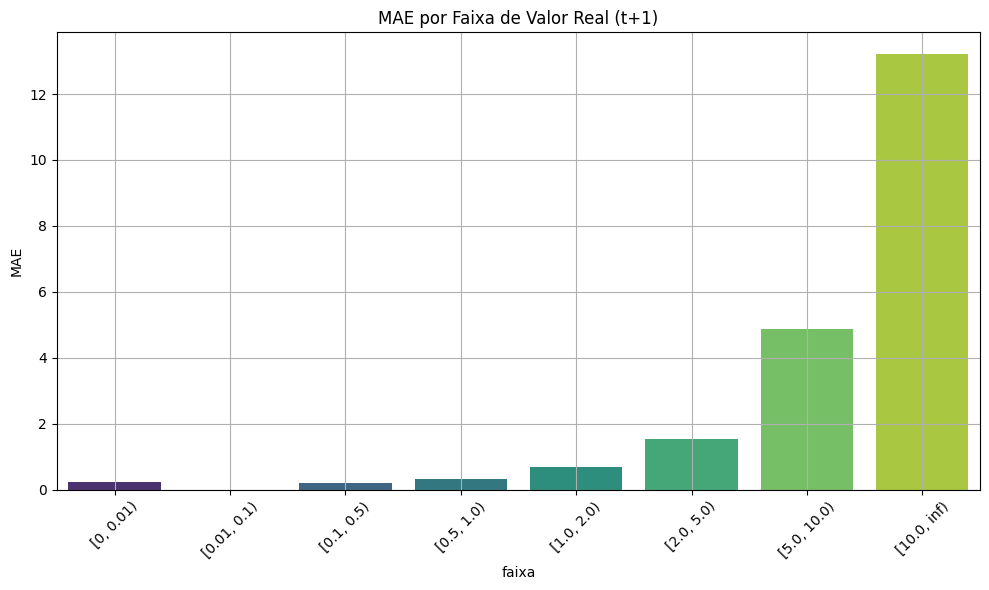

In [20]:
grouped_metrics = evaluate_by_range(y_val, y_pred_val)
display(grouped_metrics)

plot_range_metrics(grouped_metrics, metric="MAE")  # Pode trocar por "RMSE" ou "R2"


In [ ]:
pip install torch torchvision torchaudio


Usando dispositivo: cpu
Epoch 01 | Val RMSE: 1.9222
Epoch 02 | Val RMSE: 1.8882
Epoch 03 | Val RMSE: 1.8540
Epoch 04 | Val RMSE: 1.9175
Epoch 05 | Val RMSE: 1.9042
Epoch 06 | Val RMSE: 1.8825
Epoch 07 | Val RMSE: 1.8956
Epoch 08 | Val RMSE: 1.8540
Epoch 09 | Val RMSE: 1.9538
Epoch 10 | Val RMSE: 1.8838
Epoch 11 | Val RMSE: 1.9119
Epoch 12 | Val RMSE: 1.8759
Epoch 13 | Val RMSE: 1.9104
Early stopping!


,RMSE,MAE,R2
train,1.3901,0.4040,0.1187
val,1.9104,0.4939,0.0411
test,1.7434,0.5005,0.0120


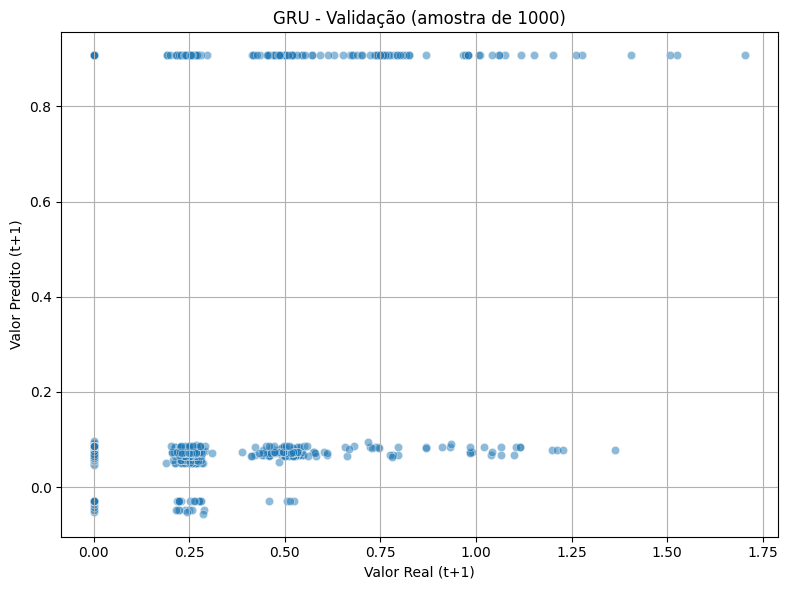

In [21]:
# === IMPORTS ===
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === CONFIGURAÇÕES ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# === MODELO GRU ===
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # pegar apenas o último passo
        return self.fc(out).squeeze()

# === PREPARANDO OS DADOS ===
def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensor = to_tensor(dataset["X_train"])
y_train_tensor = to_tensor(dataset["y_train"])
X_val_tensor = to_tensor(dataset["X_val"])
y_val_tensor = to_tensor(dataset["y_val"])
X_test_tensor = to_tensor(dataset["X_test"])
y_test_tensor = to_tensor(dataset["y_test"])

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

# === INSTANCIANDO MODELO ===
model = GRURegressor(input_size=X_train_tensor.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# === TREINAMENTO COM EARLY STOPPING ===
best_val_loss = float('inf')
patience = 5
epochs = 50
wait = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validação
    model.eval()
    with torch.no_grad():
        val_preds, val_targets = [], []
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu()
            val_preds.append(preds.numpy())
            val_targets.append(yb.numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_loss = mean_squared_error(val_targets, val_preds)

    print(f"Epoch {epoch+1:02d} | Val RMSE: {np.sqrt(val_loss):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# === AVALIAÇÃO FINAL ===
model.load_state_dict(best_model_state)
model.eval()

def predict(loader):
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu()
            preds.append(pred.numpy())
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

y_pred_train, y_train_real = predict(train_loader)
y_pred_val, y_val_real = predict(val_loader)
y_pred_test, y_test_real = predict(test_loader)

# === FUNÇÃO DE MÉTRICAS ===
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

metrics = {
    "train": compute_metrics(y_train_real, y_pred_train),
    "val": compute_metrics(y_val_real, y_pred_val),
    "test": compute_metrics(y_test_real, y_pred_test)
}

metrics_df = pd.DataFrame(metrics).T.round(4)
display(metrics_df)

# === GRÁFICO DE DISPERSÃO (validação) ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_real[:1000], y=y_pred_val[:1000], alpha=0.5)
plt.xlabel("Valor Real (t+1)")
plt.ylabel("Valor Predito (t+1)")
plt.title("GRU - Validação (amostra de 1000)")
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Percentual de zeros:
Treino:     63.37%
Validação:  51.99%
Teste:      47.84%


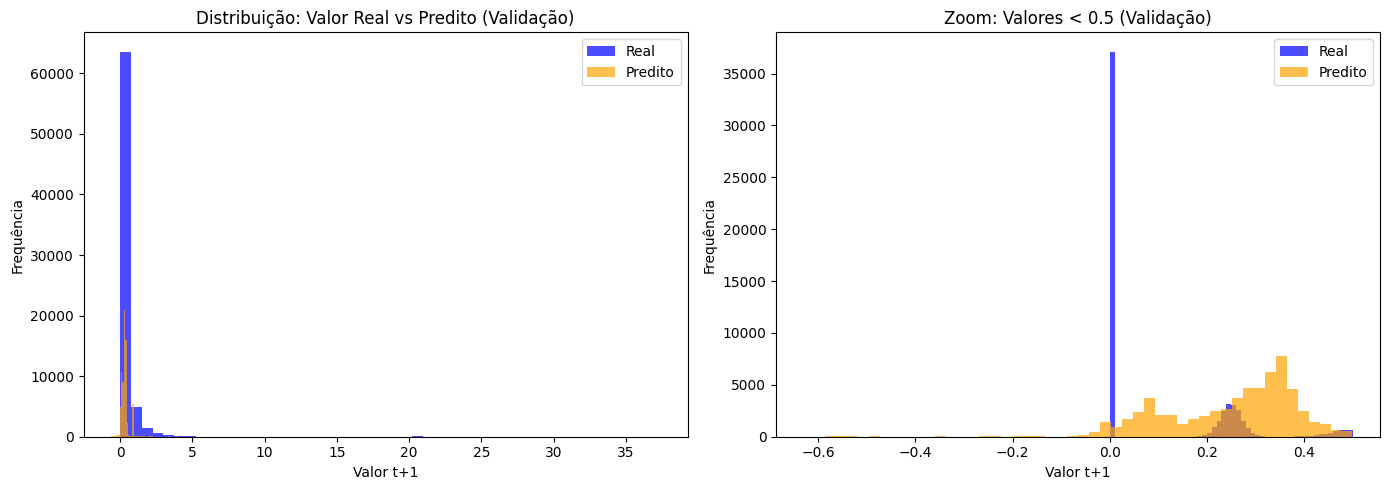

In [22]:
avaliar_esparsidade(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test)

C:\Users\pedro\AppData\Local\Temp\ipykernel_10008\385005573.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("faixa", observed=True).apply(


,faixa,Qtd. Amostras,RMSE,MAE,R2
0,"[0, 0.01)",37119.0,0.380326,0.287953,0.000000
1,"[0.1, 0.5)",21070.0,0.339708,0.194801,-14.637167
2,"[0.5, 1.0)",8005.0,0.465464,0.390646,-8.816224
3,"[1.0, 2.0)",3356.0,1.062327,1.002693,-12.981308
4,"[2.0, 5.0)",1290.0,2.534296,2.410928,-11.796093
5,"[5.0, 10.0)",84.0,6.093445,5.993757,-29.361439
6,"[10.0, inf)",476.0,22.259866,21.777346,-22.480434


C:\Users\pedro\AppData\Local\Temp\ipykernel_10008\385005573.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="faixa", y=metric, data=df, palette="viridis")


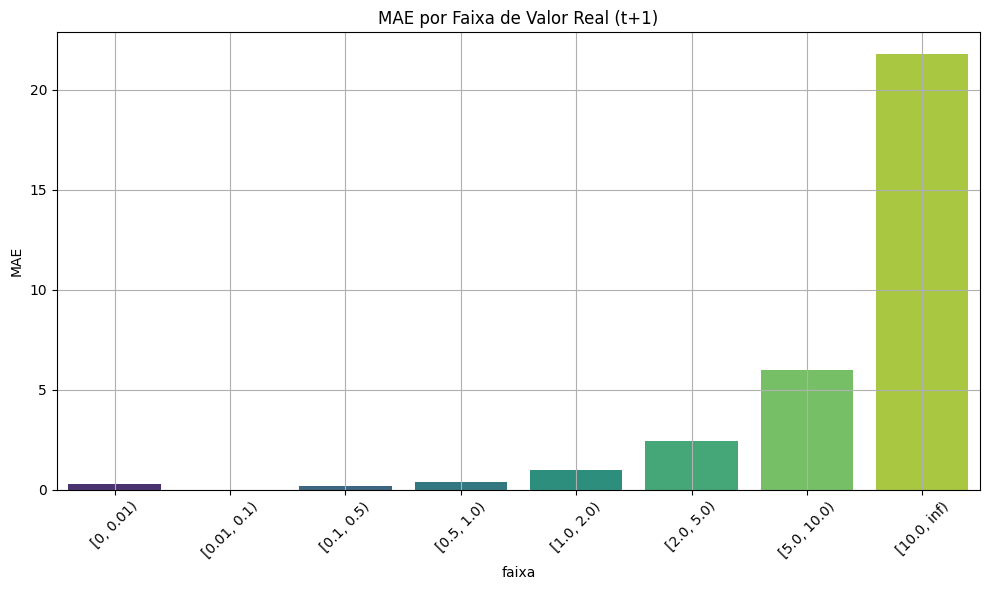

In [23]:
grouped_metrics = evaluate_by_range(y_val, y_pred_val)
display(grouped_metrics)

plot_range_metrics(grouped_metrics, metric="MAE")  # Pode trocar por "RMSE" ou "R2"
